In [0]:
#https://drive.google.com/open?id=1jgg7I6tLqB6ahus-g1GKCmEpyv7dceOC
!pip install PyDrive
!pip install hpelm

import os                                  # to access google drive as bigger files are downloaded from there
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 31.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive
     |████████████████████████████████| 51kB 19.2MB/s 


In [0]:
auth.authenticate_user()          # sign in for google drive
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1S0D5o1pQKijIFLKIBKPjGWWhhbhiHh25'})
download.GetContentFile('dataset2.zip')
!unzip dataset2.zip
!ls

In [0]:
!pip install spectral
#!rm -r /content/indian_pines                                      #comment if indian pines
#!git clone https://github.com/shriya999/indian_pines.git          #comment if indian pines
!ls

    100% |████████████████████████████████| 143kB 8.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/93/7e/15/a200ebb0b557d54eb396234737f9593ce705ed98a954bf148b
Successfully built spectral
rm: cannot remove '/content/indian_pines': No such file or directory
Cloning into 'indian_pines'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.
adc.json      indian_pines   PaviaU.mat		    Salinas_gt.mat
dataset2.zip  PaviaU_gt.mat  Salinas_corrected.mat  sample_data


PRE-PROCESSING

In [0]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage

In [0]:
def loadIndianPinesData():
    data_path = os.path.join('/content/indian_pines/')                                                     #for indian pines
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    
    data_path2 = os.path.join('/content/')                                                                  #for pavia dataset
    data2 = sio.loadmat(os.path.join(data_path2, 'PaviaU.mat'))['paviaU']
    labels2 = sio.loadmat(os.path.join(data_path2, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data2, labels2
  
def splitTrainTestSet(X, y, testRatio=0.10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test
  
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY
  
def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler
  
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca
  
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [0]:
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
  
  
def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)
    
    
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train
  
def savePreprocessedData(X_trainPatches, X_testPatches, y_trainPatches, y_testPatches, windowSize, wasPCAapplied = False, numPCAComponents = 0, testRatio = 0.25):
    if wasPCAapplied:
        with open("/content/indian_pines/Xtrain.npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open("/content/indian_pines/Xtest.npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open("/content/indian_pines/ytrain.npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open("/content/indian_pines/ytest.npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
    else:
        with open("/content/indian_pines/Xtrain.npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open("/content/indian_pines/Xtest.npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open("/content/indian_pines/ytrain.npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open("/content/indian_pines/ytest.npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)

In [0]:
# Global Variables
numComponents = 30
windowSize = 5
testRatio = 0.25
NUM_CLASS = 9
X, y = loadIndianPinesData()
print(X.shape, y.shape)

(610, 340, 103) (610, 340)


TRIALS OF GMLC/SAM

Setting min samples to 30
Processing...  0.0%Processing... 11.1%Processing... 22.2%Processing... 33.3%Processing... 44.4%Processing... 55.6%Processing... 66.7%Processing... 77.8%Processing... 88.9%Processing... 100.0%Processing...done   
GMLC:  98.66055930568949
SAM:  94.32401157184185
Setting min samples to 8
Processing...  0.0%Processing... 11.1%Processing... 22.2%Processing... 33.3%Processing... 44.4%Processing... 55.6%Processing... 66.7%Processing... 77.8%Processing... 88.9%Processing... 100.0%Processing...done   
GMLC with fisher:  97.49758919961427


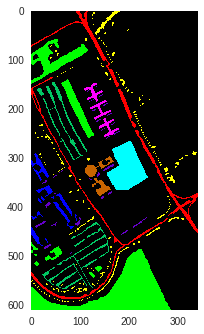

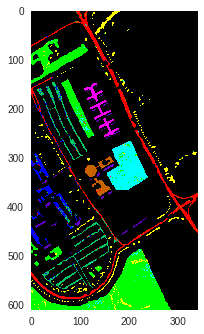

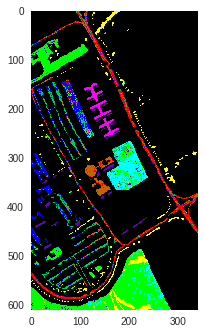

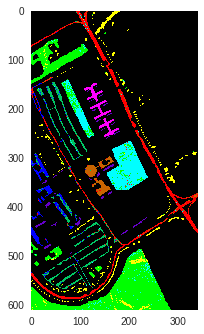

In [0]:
import numpy as np
from spectral import *

img,gt=X,y
v = imshow(classes=gt)
classes = create_training_classes(img, gt, True)

gmlc = GaussianClassifier(classes)                 #the gaussian classifier
clmap = gmlc.classify_image(img)
gtresults = clmap * (gt != 0)           #view results for only the ground truth pixels we must mask out all the pixels not associated with a training class.
gmlc_out=gtresults
v = imshow(classes=gtresults)
gterrors = gtresults * (gtresults != gt) #To view only the errors, we must mask out all elements in gtResults that do not match the ground truth image.
#v = imshow(classes=gterrors)
total=clmap.shape[0] * clmap.shape[1]
correct=np.sum(gtresults==gt)                 #no of correct predictions
print ( "GMLC: ",(correct)*100.0/(total) )             #accuracy

means = np.zeros((len(classes), img.shape[2]), float)  #the Spectral Angle Mapper classifier
for (i, c) in enumerate(classes):
   means[i] = c.stats.mean
angles = spectral_angles(img, means)                   
clmap = np.argmin(angles,2)
gtresults = (clmap+1) * (gt != 0)
v = imshow(classes=gtresults)
correct=np.sum(gtresults==gt)
print ( "SAM: ",(correct)*100.0/(total) )  

fld = linear_discriminant(classes)                 #fisher linear discriminant classifier
img_fld = fld.transform(img)
classes.transform(fld.transform)
gmlc = GaussianClassifier(classes)
clmap = gmlc.classify_image(img_fld)
gtresults = clmap * (gt != 0)          
v = imshow(classes=gtresults)
correct=np.sum(gtresults==gt)                 
print ( "GMLC with fisher: ",(correct)*100.0/(total) )             

In [0]:
pc = principal_components(img)                                 #with PCA accuracy is worse
pc_0999 = pc.reduce(fraction=0.999)
img_pc = pc_0999.transform(img)
classes = create_training_classes(img_pc, gt,True)
gmlc = GaussianClassifier(classes)
clmap = gmlc.classify_image(img_pc)
gtresults = clmap * (gt != 0)            
total=clmap.shape[0] * clmap.shape[1]
correct=np.sum(gtresults==gt)                 
print ( "GMLC: ",(correct)*100.0/(total) )         

Setting min samples to 16
Processing...  0.0%Processing... 11.1%Processing... 22.2%Processing... 33.3%Processing... 44.4%Processing... 55.6%Processing... 66.7%Processing... 77.8%Processing... 88.9%Processing... 100.0%Processing...done   
GMLC:  98.49614271938283


TRAINING THE MODEL


In [0]:
X,pca = applyPCA(X,numComponents=numComponents)
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
X_train = AugmentData(X_train)
print(X_train.shape)
#savePreprocessedData(X_train, X_test, y_train, y_test, windowSize = windowSize,wasPCAapplied=True, numPCAComponents = numComponents,testRatio = testRatio)  #comment if not indian pines

(128051, 5, 5, 30)


In [0]:
import numpy as np
import scipy
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
# Global Variables
windowSize = 5
numPCAcomponents = 30
testRatio = 0.25
#X_train = np.load("/content/indian_pines/Xtrain.npy")                #comment if not indian pines
#y_train = np.load("/content/indian_pines/ytrain.npy")                #comment if not indian pines

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[3], X_train.shape[1], X_train.shape[2]))  # Reshape into (numberofsamples, channels, height, width)
y_train = np_utils.to_categorical(y_train)        # convert class labels to on-hot encoding
print(y_train.shape)
input_shape= X_train[0].shape                     # Define the input shape 
print(input_shape)
C1 = 3*numPCAcomponents                           # number of filters

(128051, 9)
(30, 5, 5)


In [0]:
# Define the model
model = Sequential()
model.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(3*C1, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(6*numPCAcomponents, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASS, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=8)

Instructions for updating:
Use tf.cast instead.
Epoch 1/8
128051/128051 [==============================] - 27s 215us/step - loss: 1.1247 - acc: 0.6104
Epoch 2/8
128051/128051 [==============================] - 25s 193us/step - loss: 0.4211 - acc: 0.8514
Epoch 3/8
128051/128051 [==============================] - 25s 193us/step - loss: 0.2798 - acc: 0.9032
Epoch 4/8
128051/128051 [==============================] - 25s 193us/step - loss: 0.2169 - acc: 0.9255
Epoch 5/8
128051/128051 [==============================] - 25s 194us/step - loss: 0.1749 - acc: 0.9396
Epoch 6/8
128051/128051 [==============================] - 25s 193us/step - loss: 0.1500 - acc: 0.9492
Epoch 7/8
128051/128051 [==============================] - 25s 193us/step - loss: 0.1287 - acc: 0.9564
Epoch 8/8
128051/128051 [==============================] - 25s 194us/step - loss: 0.1145 - acc: 0.9617


In [0]:
import h5py
from keras.models import load_model
model.save('/content/indian_pines/my_model.h5')

Trial2: CNN+ELM

In [0]:
# coding: utf-8
import hpelm
ELM_HIDDEN_NEURONS = 350

In [0]:
#X_test = np.load("/content/indian_pines/Xtest.npy")                  #comment if not indian pines
#y_test = np.load("/content/indian_pines/ytest.npy")                  #comment if not indian pines
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))
y_test = np_utils.to_categorical(y_test)
model = load_model('/content/indian_pines/my_model.h5')

In [0]:
from sklearn.metrics import accuracy_score

y_preds = model.predict(X_train)
elm_model = hpelm.elm.ELM(y_preds.shape[1], NUM_CLASS)
elm_model.add_neurons(ELM_HIDDEN_NEURONS, func='sigm')
elm_model.train(y_preds, y_train, 'c')

y_testpred=model.predict(X_test)
elm_result = elm_model.predict(y_testpred)
elm_pred = np.argmax(elm_result, axis=1)
y_tester=np.argmax(y_test,axis=1)

total=elm_pred.shape[0]
correct=np.sum(elm_pred==y_tester)
print (correct)
print ((correct*100.0)/total)                     #the accuracy

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


/usr/local/lib/python3.6/dist-packages/hpelm/nnets/slfn_python.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B = np.linalg.lstsq(HH, HT)[0]


10381
97.07312511688798


In [0]:
# Import the necessary libraries
from sklearn.decomposition import PCA
import os
import scipy.io as sio
import numpy as np
from keras.models import load_model
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import spectral

In [0]:
#target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn','Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed','Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill','Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives','Stone-Steel-Towers']
#target_names2=['Water','Trees','Asphalt','Self-Blocking Bricks','Bitumen','Tiles','Shadows','Meadows','Bare Soil']       #for pavia
target_names3=['Asphalt','Meadows','Gravel','Trees','Painted metal sheets','Bare Soil','Bitumen','Self-Blocking Bricks','Shadows']      #for paviaU
classification = classification_report(np.argmax(y_test, axis=1), elm_pred, target_names=target_names3)
confusion = confusion_matrix(np.argmax(y_test, axis=1), elm_pred)
print(classification,confusion)    

                      precision    recall  f1-score   support

             Asphalt       0.99      0.97      0.98      1658
             Meadows       0.99      0.98      0.99      4662
              Gravel       0.88      0.88      0.88       525
               Trees       0.99      0.99      0.99       766
Painted metal sheets       1.00      1.00      1.00       336
           Bare Soil       0.93      0.98      0.96      1257
             Bitumen       0.95      0.98      0.97       332
Self-Blocking Bricks       0.90      0.91      0.91       921
             Shadows       1.00      1.00      1.00       237

           micro avg       0.97      0.97      0.97     10694
           macro avg       0.96      0.97      0.96     10694
        weighted avg       0.97      0.97      0.97     10694
 [[1613    0    0    0    0    1   16   28    0]
 [   1 4566    0   10    0   84    0    1    0]
 [   3    0  463    0    0    0    0   59    0]
 [   0    3    0  762    0    0    0    1    0]

VALIDATION AND CLASSIFICATION FOR CNN

In [0]:
# Global Variables
windowSize = 5
numPCAcomponents = 30
testRatio = 0.25

In [0]:
def reports (X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names3)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy

def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [0]:
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion = str(confusion)
file_name = 'report' + "WindowSize" + str(windowSize) + "PCA" + str(numComponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

!cat /content/reportWindowSize5PCA30testRatio0.25.txt

10694/10694 [==============================] - 1s 84us/step
8.680615702733517 Test loss (%)
96.87675331961849 Test accuracy (%)

                      precision    recall  f1-score   support

             Asphalt       0.99      0.96      0.98      1658
             Meadows       0.99      0.98      0.99      4662
              Gravel       0.88      0.85      0.87       525
               Trees       0.98      1.00      0.99       766
Painted metal sheets       1.00      1.00      1.00       336
           Bare Soil       0.93      0.98      0.96      1257
             Bitumen       0.93      0.99      0.96       332
Self-Blocking Bricks       0.89      0.92      0.91       921
             Shadows       0.99      1.00      1.00       237

           micro avg       0.97      0.97      0.97     10694
           macro avg       0.95      0.97      0.96     10694
        weighted avg       0.97      0.97      0.97     10694

[[1596    0    6    0    0    0   25   29    2]
 [   0 4565   

In [0]:
# load the original image
X, y = loadIndianPinesData()
X,pca = applyPCA(X,numComponents=numComponents)
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 5
numComponents = 30

In [0]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        k=int(PATCH_SIZE/2)
        target = int(y[i+k,j+k])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image))                         
            outputs[i+k][j+k] = prediction+1

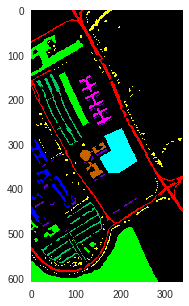

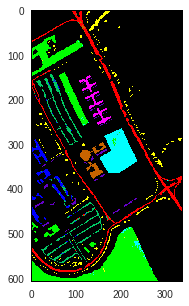

In [0]:
ground_truth = spectral.imshow(classes = y,figsize =(5,5))
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

WATERSHED SEGMENTATION MAP

(610, 340)


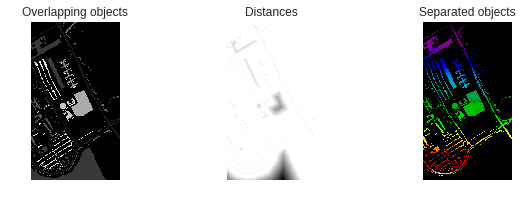

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from collections import Counter

image=y
print(image.shape)
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()                                           #here we see severe oversegmentation as each small minima is assigned its own region
fig.tight_layout()
plt.show()

(610, 340)
CNN+watershed:  99.44069431051109


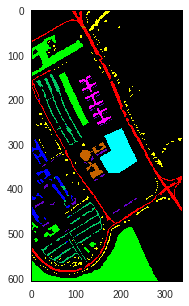

In [0]:
# MAJORITY VOTE
print(labels.shape)
uni=np.unique(labels)                     #generating the unique regions
final = np.zeros((height,width))

for i in uni:
  arr=[]
  for j in range(height-PATCH_SIZE+1):
    for k in range(width-PATCH_SIZE+1):
      m=int(PATCH_SIZE/2)
      target = int(y[j+m,k+m])
      if target == 0 :
        continue
      else:        
        if(labels[j+m][k+m]==i):
          arr.append(outputs[j+m][k+m])                 #collecting class values for a region
  cl=np.bincount(arr).argmax()
  for j in range(height-PATCH_SIZE+1):
    for k in range(width-PATCH_SIZE+1):
      m=int(PATCH_SIZE/2)
      target = int(y[j+m,k+m])
      if target == 0 :
        continue
      else:        
        if(labels[j+m][k+m]==i):
          final[j+m][k+m]=cl                         #assigning the most common class value to that region

final_image = spectral.imshow(classes = final.astype(int),figsize =(5,5))
total=final.shape[0]*final.shape[1]
correct=np.sum(final==y)                 
print ( "CNN+watershed: ",(correct)*100.0/(total) )

(610, 340)
gmlc+watershed:  99.29315332690453


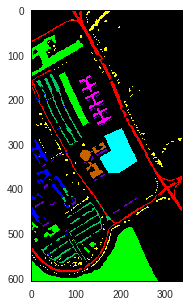

In [0]:
# MAJORITY VOTE
print(labels.shape)
uni=np.unique(labels)                     #generating the unique regions
final = np.zeros((height,width))

for i in uni:
  arr=[]
  for j in range(height-PATCH_SIZE+1):
    for k in range(width-PATCH_SIZE+1):
      m=int(PATCH_SIZE/2)
      target = int(y[j+m,k+m])
      if target == 0 :
        continue
      else:        
        if(labels[j+m][k+m]==i):
          arr.append(gmlc_out[j+m][k+m])                 #collecting class values for a region
  cl=np.bincount(arr).argmax()
  for j in range(height-PATCH_SIZE+1):
    for k in range(width-PATCH_SIZE+1):
      m=int(PATCH_SIZE/2)
      target = int(y[j+m,k+m])
      if target == 0 :
        continue
      else:        
        if(labels[j+m][k+m]==i):
          final[j+m][k+m]=cl                         #assigning the most common class value to that region

final_image = spectral.imshow(classes = final.astype(int),figsize =(5,5))
total=final.shape[0]*final.shape[1]
correct=np.sum(final==y)                 
print ( "gmlc+watershed: ",(correct)*100.0/(total) )